In [1]:
# COMENZAMOS CON EL ENTRENAMIENTO DE LOS MODELOSfrom sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sys import path
sys.path.append('C:\\Users\\Laura\\Desktop\\Nueva carpeta\\Code\\util')

from funciones import graficos_conf_matrix


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score,confusion_matrix,recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

import pickle
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [2]:
# IMPORTAMOS EL CSV YA LIMPIO .
# LO VAMOS A DIVIDIR EN DOS, UNA PARTE PARA EL ENTRENAMIENTO-PREDICCIONES Y OTRA PARTE PARA EL TEST, COMO SI DE DATOS REALES SE TRATARAN


data_train = pd.read_csv('../Data/Processed/data_processed.csv', index_col=0)

data_train = data_train.iloc[:int(data_train.shape[0]*60/100), :]
data_test = data_train.iloc[int(data_train.shape[0]*60/100) : , :]





In [3]:
# DIVIDIMOS EN DATA_TRAIN EN TRAIN Y TEST


X_train, X_test, y_train, y_test = train_test_split(data_train.drop(columns=['Target','Anxiety','Stress'], axis=1), data_train.Target, random_state=0, test_size=0.20, shuffle=True)

scale = MinMaxScaler()
scale.fit(X_train)

X_train_scale = scale.transform(X_train)
X_test_scale= scale.transform(X_test)


KNN

In [4]:
# CON KNN VAMOS A VER PRIMERO CUAL ES EL MEJOR VALOR DE LA K SIN UTILIZAR GRIDSEARCH NI PIPELINE. ADEMAS ESCALO LOS DATOS PRIMERO

In [5]:
k_range= range(1,100)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(k)
    knn.fit(X_train_scale, y_train)
    scores.append(knn.score(X_test_scale, y_test))


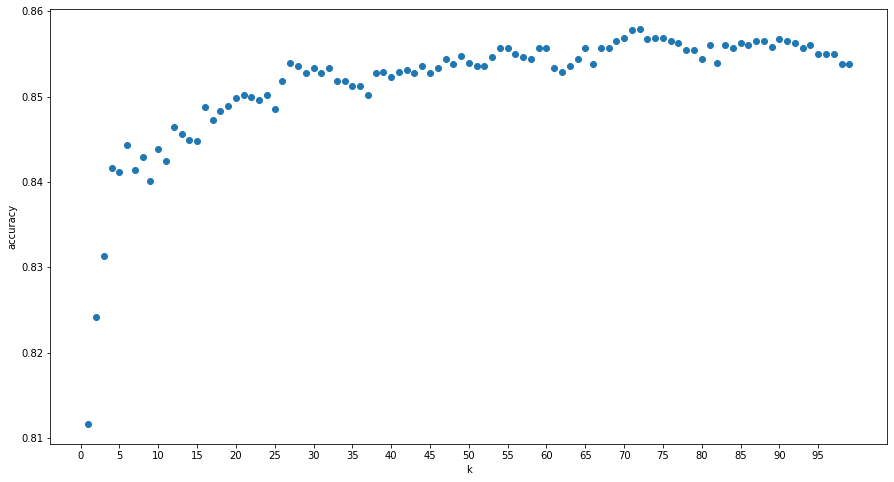

In [6]:
plt.figure(figsize=(15,8))

plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks(np.arange(0,100,5));

In [7]:
np.array(k_range)[scores ==max(scores)]

array([72])

In [8]:
X_train

,urban,age,gender,religion,orientation,married,race,familysize,Depression
12078,2,15,2,2,3,1,60,2,36
2396,1,26,2,4,1,2,10,1,33
6472,3,16,2,10,1,1,10,2,6
16588,1,20,2,10,2,1,10,4,34
8740,2,22,2,10,1,1,10,5,2
...,...,...,...,...,...,...,...,...,...
13123,2,27,2,7,1,1,60,2,3
19648,3,36,2,10,1,1,10,3,29
9845,3,16,2,10,2,1,10,3,40
10799,3,17,2,4,1,1,60,3,9


In [9]:
X_train = scale.inverse_transform(X_train_scale)
X_test = scale.inverse_transform(X_test_scale)
X_train

array([[ 2., 15.,  2., ..., 60.,  2., 36.],
       [ 1., 26.,  2., ..., 10.,  1., 33.],
       [ 3., 16.,  2., ..., 10.,  2.,  6.],
       ...,
       [ 3., 16.,  2., ..., 10.,  3., 40.],
       [ 3., 17.,  2., ..., 60.,  3.,  9.],
       [ 3., 22.,  2., ..., 60.,  3., 22.]])

In [10]:
# A PESAR DE QUE EL MEJOR VALOR DE K SEGUN LAS INDICACIONES PREVIAS ES 59, VAMOS A PROBAR TB CON EL 27 Y 40
# 
# CREACION DE PIPELINE INICIAL.
# HACEMOS UN RANDOMIZW CROSS VALIDATIION
# LO INSTANCIAMOS

model_knn = Pipeline (steps = [
                     ('scaler', MinMaxScaler()),
                     ('knn', KNeighborsClassifier())]
                    )  


params = {'knn__n_neighbors' : range(20,75,1)
         }


model_knn_gtc = RandomizedSearchCV(model_knn, params, cv=5, scoring='roc_auc')
model_knn_gtc.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('knn', KNeighborsClassifier())]),
                   param_distributions={'knn__n_neighbors': range(20, 75)},
                   scoring='roc_auc')

In [11]:
# SACAMOS LOS MEJORES PARÁMETROS PARA ENTRENAR EL MODELO

print (model_knn_gtc.best_params_)
print (model_knn_gtc.best_estimator_)

{'knn__n_neighbors': 56}
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=56))])


In [12]:
#CREAMOS UN NUEVO PIPELINE CON EL RESULTADO MEJOR RESULTADO DEL GRIDSEARCH
model_knn_V2 = model_knn_gtc.best_estimator_

In [13]:
model_knn_V2

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=56))])

In [14]:
# ENTRENAMOS EL MODELO Y SACAMOS LAS PREDICCIONES

model_knn_V2.fit(X_train,y_train)
y_predi = model_knn_V2.predict(X_test)

In [15]:
y_predi

array([1, 0, 1, ..., 0, 1, 0], dtype=int64)

In [16]:
# PASAMOS LAS METRICAS A UN DATAFRAM

# df_scores = pd.read_csv('../Model/scores_models_Roc.csv', index_col=0)
# df_scores['knn_data_train'] =[recall_score(y_test,y_predi), roc_auc_score(y_test,y_predi),  accuracy_score(y_test, y_predi), f1_score(y_test, y_predi)]


# df_scores

In [17]:
# GUARDAMOS LA CONFUSION MATRIX PARA DESPUES GRAFICARLA
c_matrix_train = confusion_matrix(y_test, y_predi)

In [18]:
# GUARDAMOS EL MODELO

with open('../Model/model_knn_V2', 'wb') as archivo_salida:
    pickle.dump(model_knn_V2, archivo_salida)

In [19]:
# PROBAMOS EL MODELO CON LOS DATOS RESERVADOS PARA VER COMO GENERALIZA

X = data_test.drop(columns=['Target','Anxiety','Stress'], axis=1)
y= data_test.Target

with open('../Model/model_knn_V2', 'rb') as archivo_entrada:
    loaded_model = pickle.load(archivo_entrada)

In [20]:
loaded_model

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=56))])

In [21]:
# PASAMOS LAS METRICAS A UN DATAFRAM
# df_scores['knn_data_test'] =[recall_score(y,loaded_model.predict(X)), roc_auc_score(y,loaded_model.predict(X)), accuracy_score(y, loaded_model.predict(X)), f1_score(y, loaded_model.predict(X))]
# df_scores.to_csv('../Model/scores_models_Roc.csv')
# df_scores

In [22]:
# GUARDAMOS LA CONFUSION MATRIX PARA DESPUES GRAFICARLA
c_matrix_test = confusion_matrix(y,loaded_model.predict(X))

C:\Users\Laura\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


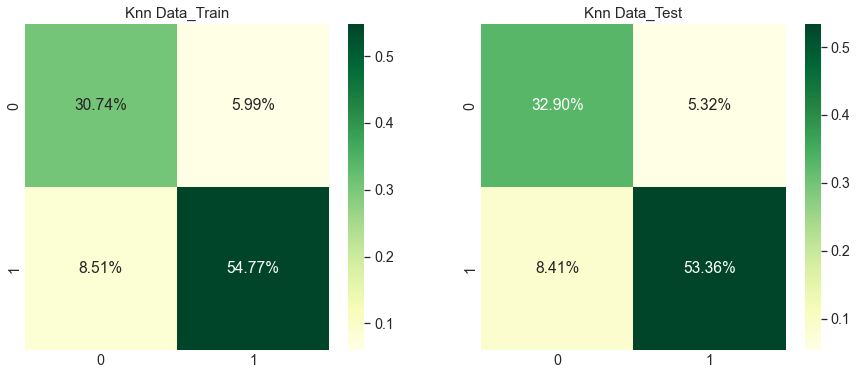

In [24]:


graf_knn_Roc_matriz = plt.figure(figsize=(15,6))



plt.style.use('seaborn-whitegrid')
plt.subplot(1,2,1)
sns.set(font_scale = 1.3)
graficos_conf_matrix(c_matrix_train,'Knn Data_Train')

plt.style.use('seaborn-whitegrid')
plt.subplot(1,2,2)
sns.set(font_scale = 1.3)
graficos_conf_matrix(c_matrix_test,'Knn Data_Test')

graf_knn_Roc_matriz.savefig ('../util/Graficos/graf_knn_Roc_matriz.png')